# LCM Spatial Wrangling

_James Millington, November 2021._

This notebook contains code used to produce data with consistent attributes for subsequent change analysis. Analysis will be similar to that presented by Clare Rowland of [UKCEH](https://www.ceh.ac.uk/) in her [ialeUK Landscape Connections](https://iale.uk/landscape-connections) talk [from 8:34](https://youtu.be/NZZvE6OH9bI?t=514). 


Data are [UK CEH LCM](https://www.ceh.ac.uk/ukceh-land-cover-maps) raster and ONS Geography vector as follows:
1. Land Cover Map 1990 - 1km dominant target class, GB v2 (Rowland _et al._ 2020)
2. Land Cover Map 2000 - 1km dominant target class, GB (Fuller _et al._ 2002)
3. Land Cover Map 2015 - 1km dominant target class, GB (Rowland _et al._ 2017)
4. Digital vector boundaries for Counties and Unitary Authorities in the UK (ONS Geography 2019)

These references are:

Fuller, R.M.; Smith, G.M.; Sanderson J.M.; Hill, R.A.; Thomson, A.G.; Cox, R.; Brown, N.J.; Clarke, R.T.; Rothery, P.; Gerard, F.F. (2002). Land Cover Map 2000 (1km dominant target class, GB). _NERC Environmental Information Data Centre._ https://doi.org/10.5285/abff8409-0995-48d2-9303-468e1a9fe3df

ONS Geography (2019) Counties and Unitary Authorities (April 2019) Boundaries GB BGC. _Office for National Statistics_ https://geoportal.statistics.gov.uk/datasets/ons::counties-and-unitary-authorities-april-2019-boundaries-gb-bgc/about 

Rowland, C.S.; Morton, R.D.; Carrasco, L.; McShane, G.; O'Neil, A.W.; Wood, C.M. (2017). Land Cover Map 2015 (1km dominant target class, GB). _NERC Environmental Information Data Centre._ https://doi.org/10.5285/c4035f3d-d93e-4d63-a8f3-b00096f597f5

Rowland, C.S.; Marston, C.G.; Morton, R.D.; O’Neil, A.W. (2020). Land Cover Map 1990 (1km dominant target class, GB) v2. NERC Environmental Information Data Centre. https://doi.org/10.5285/f5e3bd00-efd0-4dc6-a454-aa597d84764a

Note the licences for these data:
- [LCM licence](https://eidc.ceh.ac.uk/licences/lcm-raster/plain) (educational use only)
- [boundary data licence](https://www.ons.gov.uk/methodology/geography/licences) (Contains both Ordnance Survey and ONS Intellectual Property Rights)

In [1]:
import rasterio as rio
import rasterio.mask
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import copy
import sys

## Raster: Initial Wrangling

The original raster data downloaded from [UKCEH](https://www.ceh.ac.uk/ukceh-land-cover-maps) we inconsistent in some of their attributes. This section fixes that, writing the data out to new `.tif` files. 

### Rasterio `DatasetReader` includes metadata

We can use the `open` [function](https://rasterio.readthedocs.io/en/latest/api/rasterio.html#rasterio.open) directly to create objects:

In [27]:
lcm1990v2 = rio.open("cw2/1990-1km/new/data/gb1990lcm1km_dominant.tif")
lcm2000 = rio.open("cw2/2000-1km/new/data/extracted/LCM2000_GB_1K_DOM_TAR.tif")
lcm2020 = rio.open("cw2/2020-1km/new/data/gb2020lcm1km_dominant_target.tif")

Note this is a `DatasetReader` object and we haven't actually read the data into memory yet:

In [28]:
print(type(lcm2020))

<class 'rasterio.io.DatasetReader'>


`DatasetReader` objects are useful because we can access information about the raster data before reading what can be very large data files into memory (taking up computer resources we might need for other data). See the attributes of `DatasetReader` objects [here](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader).

For example, we can access the metadata of the raster file using the `meta` method on the `DatasetReader` object:  

In [29]:
lcm1990v2.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 700,
 'height': 1300,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(1000.0, 0.0, 0.0,
        0.0, -1000.0, 1300000.0)}

In [30]:
lcm2000.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 700,
 'height': 1300,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(1000.0, 0.0, 0.0,
        0.0, -1000.0, 1300000.0)}

In [31]:
lcm2020.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 700,
 'height': 1300,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(1000.0, 0.0, 0.0,
        0.0, -1000.0, 1300000.0)}

The `meta` attribute is a dictionary containing the basic metadata of the dataset. It contains information on:
- driver: the file format ([using](https://rasterio.readthedocs.io/en/latest/api/rasterio.drivers.html) GDAL standard); examples include GeoTiff and NetCDF
- dtype: the data type(s) of band(s) in the dataset (in index order); examples include int and float
- nodata: the value used to indicate pixels that do not contain valid data
- width: the number of pixels in the horizontal
- height: the number of pixels in the vertial
- count: the number of bands in the dataset
- crs: the coordinate reference system (i.e. the definition of the real-world system in which a raster’s pixels are located)
- transform: the parameters by which pixel coordinates (in the data grid) are transformed into coordinates in the CRS (see more [here](https://rasterio.readthedocs.io/en/latest/topics/georeferencing.html))


From the output above we can see the datasets are very similar but not identical, with differences in:
1. `driver`: The 2015 file is in Erdas Imagine (`.img`) format, which the reader recognises. Once the data are read, this shouldn't make a difference. 
2. `nodata`: I believe all of these are incorrect as additional metadata online suggests the `nodata` value is likely zero (as it is not included in the classification table) and the 255 is likely from RGB bands (pre-classification)
3. `CRS`: this is likely actually the same for all datasets, both because the source of the data is the same (CEH) and because [EPSG 27700](https://epsg.io/27700) (`from_epsg` in the 2015 dataset) is OSBG 1936 (`from_wkt` in the 1990 dataset). 2000 and 2015 have definition `from_wkt`, 1990 from `from_epsg`

To update the metadata (so that all three datafiles are consistent) we can use the `update` method on the `profile` attribute and then write the new file to disk. 

In [35]:
out_profile = lcm1990v2.profile
out_profile.update({"nodata": 0,})

#https://rasterio.readthedocs.io/en/latest/topics/writing.html
with rio.Env():
    
    with rio.open('data/output/lcm1990v2-1km-tar-dom-gb.tif', 'w', **out_profile) as dst:
        dst.write(lcm1990v2.read(1),1) 

In [36]:
out_profile = lcm2000.profile
out_profile.update({"nodata": 0})

#https://rasterio.readthedocs.io/en/latest/topics/writing.html
with rio.Env():
    
    with rio.open('data/output/lcm2000-1km-tar-dom-gb.tif', 'w', **out_profile) as dst:
        dst.write(lcm2000.read(1),1) 

In [38]:
out_profile = lcm2020.profile
out_profile.update({"nodata": 0})

#https://rasterio.readthedocs.io/en/latest/topics/writing.html
with rio.Env():
    
    with rio.open('cw2/data/output/lcm2020-1km-tar-dom-gb.tif', 'w', **out_profile) as dst:
        dst.write(lcm2020.read(1),1) 

When we read these new files back in, we can see that they now have consistent metadata

In [39]:
lcm1990v2 = rio.open('data/output/lcm1990v2-1km-tar-dom-gb.tif')
lcm2000 = rio.open('data/output/lcm2000-1km-tar-dom-gb.tif')
lcm2015 = rio.open('cw2/data/output/lcm2020-1km-tar-dom-gb.tif')

In [40]:
lcm1990v2.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 700,
 'height': 1300,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(1000.0, 0.0, 0.0,
        0.0, -1000.0, 1300000.0)}

In [41]:
lcm2000.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 700,
 'height': 1300,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(1000.0, 0.0, 0.0,
        0.0, -1000.0, 1300000.0)}

In [42]:
lcm2020.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 700,
 'height': 1300,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(1000.0, 0.0, 0.0,
        0.0, -1000.0, 1300000.0)}

## Vector

The vector data we will use are from [ONS Geography](https://geoportal.statistics.gov.uk/datasets/ons::counties-and-unitary-authorities-april-2019-boundaries-gb-bgc/about) (2019)

In [44]:
lads = gpd.read_file("vector/Counties_and_Unitary_Authorities_(April_2019)_Boundaries_GB_BGC.geojson").set_index('objectid')
lads.head()


,ctyua19cd,ctyua19nm,ctyua19nmw,bng_e,bng_n,long,lat,st_areashape,st_lengthshape,geometry
objectid,,,,,,,,,,
1,E06000001,Hartlepool,,447157,531476,-1.27023,54.676159,9.364022e+07,69232.916248,"MULTIPOLYGON (((-1.23306 54.62741, -1.23292 54..."
2,E06000002,Middlesbrough,,451141,516887,-1.21099,54.544670,5.387847e+07,42081.032562,"MULTIPOLYGON (((-1.20035 54.57697, -1.20040 54..."
3,E06000003,Redcar and Cleveland,,464359,519597,-1.00611,54.567520,2.448736e+08,96004.895063,"MULTIPOLYGON (((-1.20036 54.57702, -1.20029 54..."
4,E06000004,Stockton-on-Tees,,444937,518183,-1.30669,54.556911,2.049584e+08,115262.590755,"MULTIPOLYGON (((-1.23878 54.62786, -1.23880 54..."
5,E06000005,Darlington,,428029,515648,-1.56835,54.535339,1.974976e+08,105784.983937,"POLYGON ((-1.43836 54.59508, -1.44000 54.59447..."


From the `geometry` column the CRS looks to be un-projected. We can check the stored CRS:

In [45]:
print(lads.crs)

epsg:4326


This is the [EPSG for WGS84](https://epsg.io/4326), _but_

> The coordinate reference system for all GeoJSON coordinates is a geographic coordinate reference system, using the [World Geodetic System 1984 (WGS 84) datum](https://epsg.io/4326), with longitude and latitude units of decimal degrees. [[source]](https://datatracker.ietf.org/doc/html/rfc7946#page-12)

So we should check this still looks like unprojected data when we plot it:  

<AxesSubplot: >

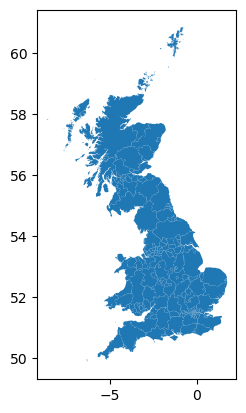

In [46]:
lads.plot()

This looks like it is unprojected (lat, long) so we will re-project to align the vector data with the raster data which use the [OSGB 1936 / British National Grid](https://en.wikipedia.org/wiki/Ordnance_Survey_National_Grid). The EPSG code of OSGB 1936 is `27700` (hence that value used in the code above). You can find ESPG codes for different CRS by [searching epsg.io](https://epsg.io).

In [47]:
lads_osbg  = lads.to_crs({'init': 'epsg:27700'})

C:\Users\noush\anaconda3\envs\sds2022\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Now when we plot:

<AxesSubplot: >

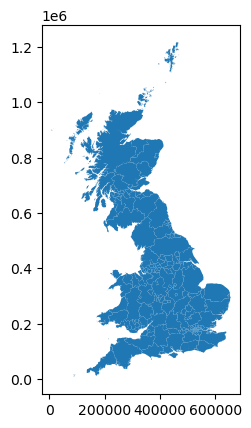

In [48]:
lads_osbg.plot()

The coordinates seem more consistent with OSBG' Let's check the coords in the `geometry` column:

In [49]:
lads_osbg.tail()

,ctyua19cd,ctyua19nm,ctyua19nmw,bng_e,bng_n,long,lat,st_areashape,st_lengthshape,geometry
objectid,,,,,,,,,,
201,W06000020,Torfaen,Torfaen,327459,200480,-3.05101,51.698360,1.262122e+08,79049.833853,"POLYGON ((333723.012 192653.907, 333682.710 19..."
202,W06000021,Monmouthshire,Sir Fynwy,337812,209231,-2.90280,51.778271,8.502912e+08,218310.870415,"MULTIPOLYGON (((327822.013 231019.604, 327495...."
203,W06000022,Newport,Casnewydd,337897,187433,-2.89769,51.582321,1.905076e+08,148747.859591,"MULTIPOLYGON (((342379.411 194677.607, 342358...."
204,W06000023,Powys,Powys,302328,273254,-3.43533,52.348629,5.195410e+09,590106.160512,"POLYGON ((322891.616 333139.303, 322820.312 33..."
205,W06000024,Merthyr Tydfil,Merthyr Tudful,305916,206424,-3.36425,51.748581,1.119431e+08,65340.207828,"POLYGON ((308057.316 211036.204, 306885.413 21..."


This look good. So now write to file:

In [50]:
lads_osbg.to_file("vector/Counties_and_Unitary_Authorities_April2019_GB_BGC_osbg.geojson", driver='GeoJSON')

## Raster: Crop and Reclassify

<a name="section2"></a>
### Crop Raster Data

From the [EarthLab cropping tutorial](https://www.earthdatascience.org/workshops/gis-open-source-python/crop-raster-data-in-python/):

> _What Does Crop a Raster Mean?_
>
>Cropping (sometimes also referred to as clipping), is when you subset or make a dataset smaller, by removing all data outside of the crop area or spatial extent. ...
This is useful as it:
>
>- Makes the data smaller and
>- Makes processing and plotting faster
>
>In general when you can, it’s often a good idea to crop your raster data!

We'll do our crop using the `rasterio mask` [function](https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html?highlight=mask#rasterio.mask.mask). To use the function, at a minimum we need to to pass it:
1. the raster `dataset` we want to crop (as a `DatasetReader` object)
2. the vector `shapes` that define the extent we want to crop to (here this is the `geometry` column of our GeoDataFrame)
2. indicate `crop=True`

In [51]:
lcm2020_gb, lcm2020_gb_transform = rasterio.mask.mask(dataset=lcm2020, shapes=lads_osbg.geometry, crop=True)

Note that the `rasterio mask` function returns two elements (potentially as a tuple):
1. a `ndarray` for data contained in the raster after applying the mask
2. a `Affine` object (also known as the `transform`) that contains information for mapping pixel coordinates in our masked raster to another coordinate system (like CRS data).  

We can check the `type` and `shape` our our new, masked, raster data: 

In [52]:
print(type(lcm2020_gb))

<class 'numpy.ndarray'>


In [53]:
lcm2020_gb.shape

(1, 1216, 651)

The `ndarray` we have created is still 3D, but now it seems to have fewer pixels in the 2D (232 vs 1300 and 197 vs 700 previously). Let's plot to visualise the new raster:  

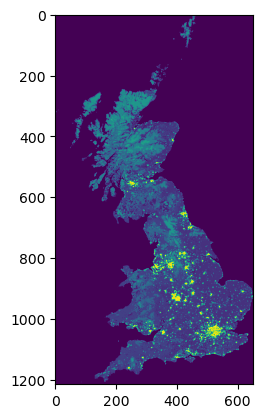

In [54]:
plt.imshow(lcm2020_gb[0], cmap='viridis')

It isn't vital we understand the contents of the `transform` data now, but note how this is similar to the `transform` attribute in the original data we read at the start of the notebook:

In [55]:
lcm2020_gb_transform

Affine(1000.0, 0.0, 5000.0,
       0.0, -1000.0, 1221000.0)

#### Write Raster to File

As we have created a new dataset, it might be useful to write this to a file on disk in case we want to share it with other or use it again in future (without needing to do all the manipulation again). An example of writing to file is shown in the [rasterio instructions on masking](https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html). We will adapt these slightly to write our own function to write our cropped raster:

In [56]:
#function to write ndarray to file as a .tif (with CRS etc)
def write_nd_to_tif(nd, meta, transform, filename):
    
    #update meta from original to new data extent and transform 
    meta.update({"driver": "GTiff",
                 "height": nd.shape[1],
                 "width": nd.shape[2],
                 "transform": transform})

    with rasterio.open(filename, "w", **meta) as dest:
        dest.write(nd)

When writing the file, not only do we need to write the raster data itself (in the `ndarray`) but also the metadata containing all the CRS and other spatial information. See how the function above takes existing an `meta` specification and updates it to the current extent of the `ndarray`. The function also uses the `Affine` (i.e. `transform`) object output from the `rasterio mask` function. 

So to use this function for our newly cropped raster:

In [57]:
write_nd_to_tif(nd=lcm2020_gb, 
                meta=lcm2020.meta, 
                transform=lcm2020_gb_transform, 
                filename="data/output/lcm2020_gb.tif")

Go and check this file has been created on disk!

### Now for 1990 and 2000!

In [58]:
lcm1990_gb, lcm1990_gb_transform = rasterio.mask.mask(dataset=lcm1990v2, shapes=lads_osbg.geometry, crop=True)
print(lcm1990_gb.shape)
print(lcm1990_gb_transform)
write_nd_to_tif(lcm1990_gb, lcm1990v2.meta, lcm1990_gb_transform, "data/output/lcm1990_gb.tif")

lcm2000_gb, lcm2000_gb_transform = rasterio.mask.mask(dataset=lcm2000, shapes=lads_osbg.geometry, crop=True)
print(lcm2000_gb.shape)
print(lcm2000_gb_transform)
write_nd_to_tif(lcm2000_gb, lcm2000.meta, lcm2000_gb_transform, "data/output/lcm2000_gb.tif")

(1, 1216, 651)
| 1000.00, 0.00, 5000.00|
| 0.00,-1000.00, 1221000.00|
| 0.00, 0.00, 1.00|
(1, 1216, 651)
| 1000.00, 0.00, 5000.00|
| 0.00,-1000.00, 1221000.00|
| 0.00, 0.00, 1.00|


<a name="section3"></a>
### Re-classify Land Cover Classes

The [Land Cover Change 1990-2015 25m product](https://www.ceh.ac.uk/services/land-cover-change-1990-2015) represents the land surface using only six classes. Other Land Cover Map products produced by UKCEH have many more classes, but for the change product the maps were re-classified to have fewer classes. 

For example, lets quickly identify the unique values in our land cover maps and how many times they are observed (i.e. how many pixels fall in each land cover class). Because are data are `numpy` objects (i.e. `ndarray`'s) we can use `numpy`'s `.unique` [function](https://numpy.org/doc/stable/reference/generated/numpy.unique.html) to [count the occurrence of each value](https://stackoverflow.com/a/28663910):

In [59]:
lcm1990_gb = rio.open('data/output/lcm1990_gb.tif')
lcm2000_gb = rio.open('data/output/lcm2000_gb.tif')
lcm2020_gb = rio.open('data/output/lcm2020_gb.tif')

lcm1990_gb15 = lcm1990_gb.read(1)
lcm2000_gb15 = lcm2000_gb.read(1)
lcm2020_gb15 = lcm2020_gb.read(1)

unique, counts = np.unique(lcm1990_gb15, return_counts=True)  #get the unique values and counts
counts1990 = dict(zip(unique, counts))                         #combine them into a dict for easier viewing

unique, counts = np.unique(lcm2000_gb15, return_counts=True)
counts2000 = dict(zip(unique, counts))

unique, counts = np.unique(lcm2020_gb15, return_counts=True)
counts2020 = dict(zip(unique, counts))

print(counts1990)
print('\n')
print(counts2000)
print('\n')
print(counts2020)

{0: 562362, 1: 5583, 2: 10277, 3: 61401, 4: 75859, 5: 846, 6: 1812, 7: 20977, 8: 154, 9: 13145, 10: 17105, 11: 6638, 12: 897, 13: 283, 14: 1418, 15: 10, 16: 279, 17: 3, 18: 244, 19: 365, 20: 2368, 21: 9590}


{0: 561577, 1: 1590, 2: 1574, 3: 1, 4: 393, 5: 238, 7: 146, 8: 4817, 9: 6419, 10: 19871, 11: 4366, 12: 8358, 13: 13632, 14: 64023, 15: 9169, 16: 324, 17: 945, 18: 4901, 19: 13251, 20: 68, 21: 23340, 22: 37689, 23: 299, 24: 11306, 25: 3308, 255: 11}


{0: 562337, 1: 8351, 2: 12575, 3: 59957, 4: 71366, 5: 1225, 6: 1124, 7: 22334, 8: 158, 9: 9945, 10: 12814, 11: 8947, 12: 2176, 13: 156, 14: 1497, 15: 61, 16: 571, 17: 45, 18: 290, 19: 795, 20: 2856, 21: 12036}


We can see there are many more `0`s than other values - these are the No Data values. For 1990 and 2015 the next highest count is for class `4` and we have 21 classes, but for 2000 the next highest count is for class `14` and there are 25 classes. Clearly we have different classifications between the years. The code below re-classifies these data into a single, consistent classification. The new classification will have six clases and so will also be simpler. 

Reclassification is quite common when working with land cover data. 

<img src="https://www.earthdatascience.org/images/earth-analytics/raster-data/reclass-raster-esri.gif" width="400px"></img>

As EarthLab [explain](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/classify-plot-raster-data-in-python/), 

> When you reclassify a raster, you create a new raster. In that raster, each cell from the old raster is mapped to the new raster. The values in the new raster are applied using a defined range of values or a raster map. For example above you can see that all cells that contains the values 1-3 are assigned the new value of 5. 

We will re-classify our 1km data for to the same classes as used in the 1990-2015 25m product. This will enable us to more closely reproduce the result presented by Clare Rowland (see top). 

But first, we'll see the proof-of-concept of how to do with with `ndarray` in python. 

### Proof of Concept

To see how re-classification works, we'll generate a small 2D `ndarray` to work with:

In [60]:
original = np.ndarray(shape=(5,5), buffer=np.arange(25), dtype=int)
print(original)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]


We need to create a ([deep](https://www.geeksforgeeks.org/copy-python-deep-copy-shallow-copy/)) copy of the `ndarray` to hold the new values after re-classification (remember when we reclassify a raster, we create a new raster): 

In [61]:
modified = copy.deepcopy(original)
print(modified)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]


Next, we need to define the re-classification rules. That is, we need to specify what values should change _from_ and _to_. A `dict` will be a useful structure to do this, as we can use the `key`s as the _from_ (old) value and the `value`s as the _to_ (new) value. 

For example, let's say we want to change values in our `ndarray` as shown in the table below, with all other values remaining the same:

| old | new |
| --- | --- |
| 5   | -1  |
| 11  | -3  |
| 17  | -2  |
| 23  | -4  |

Our `dict` to do this would look like the following:

In [62]:
changes = {5: -1, 11: -3, 17: -2, 23:-4}

Now we can loop over this `dict` using the `key` to identify _old_ values in the `ndarray` to change to _new_: 

In [63]:
for old, new in changes.items(): 
    modified[original==old]=new

Printing out our two rasters now we can compare the result of the re-classification:

In [64]:
print(original)
print('\n')
print(modified)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]


[[ 0  1  2  3  4]
 [-1  6  7  8  9]
 [10 -3 12 13 14]
 [15 16 -2 18 19]
 [20 21 22 -4 24]]


Check you understand how the modified `ndarray` (below) results from the re-classification of the original (above) as we wanted.

### Re-classification for Wales

We re-classify data for 1990 and 2015 first, then do 2000 later (as they will require a different re-classification scheme). 

First, we create copies of the input raster maps (but only the single 2D layer!):

In [66]:
lcm2020_gb6 = copy.deepcopy(lcm2020_gb15)
lcm1990_gb6 = copy.deepcopy(lcm1990_gb15)

print(lcm2020_gb6.shape)
print(lcm1990_gb6.shape)

(1216, 651)
(1216, 651)


Now we need to define our reclassification dictionary. The reclassification we will use is shown in Table 3 of the [Supporting Documentation](https://doi.org/10.5285/07b6e5e9-b766-48e5-a28c-5b3e35abecc0) for Rowland _et al._ (2020b) as shown in the image below:

<img src="https://www.landscapemodelling.net/png/Table3_Rowland2020.png" width="500px"></img>

Thus, our six simplified classes (from the original 21) will be:
1. Woodland
2. Cropland
3. Grassland
4. Water
5. Built-up
6. Other

From the re-classification table above, our dictionary will be:

In [67]:
lookup = {1:1,2:1,
          3:2,
          4:3,5:3,6:3,7:3,8:3,9:3,10:3,11:3,16:3,18:3,19:3,
          14:4,
          20:5,21:5,
          12:6,13:6,15:6,17:6}

Check you can see how the dictionary corresponds to Table 3 above. Remember, `key`s are _from_ and `value`s are _to_ and we're going from 21 classes to 6. 

We can now loop over the dictionary to modify values in both copies of the land cover maps: 

In [68]:
for old, new in lookup.items(): 
    lcm2020_gb6[lcm2020_gb15 == old]=new
    lcm1990_gb6[lcm1990_gb15 == old]=new

Quick reminder of the shape of the `ndarray` we've produced:

In [69]:
lcm2020_gb6.shape

(1216, 651)

We can check if this has been successful by examining the unique values and counts of the new raster maps:

In [70]:
unique, counts = np.unique(lcm1990_gb6, return_counts=True)  #get the unique values and counts
counts1990_6 = dict(zip(unique, counts))                         #combine them into a dict for easier viewing

unique, counts = np.unique(lcm2020_gb6, return_counts=True)
counts2020_6 = dict(zip(unique, counts))

print(counts1990_6)
print('\n')
print(counts2020_6)

{0: 562362, 1: 15860, 2: 61401, 3: 137424, 4: 1418, 5: 11958, 6: 1193}


{0: 562337, 1: 20926, 2: 59957, 3: 129569, 4: 1497, 5: 14892, 6: 2438}


Looks good!


Now for the 2000 data. As we saw above we have different counts and classes in the original 2000 data, so we need a different re-classification for 2000 (than for 1990 and 2015). For the reclass we should actually refer to the table in _lcm2000_raster_dataset_details.pdf_ but then otherwise we follow the same process:

In [71]:
d2000 = {12:1,13:1,
         21:2,22:2,23:2,
         4:3,5:3,7:3,8:3,9:3,10:3,14:3,15:3,16:3,16:3,17:3,18:3,19:3,20:3,
         1:4,2:4,
         24:5,25:5,
         6:6,11:6,26:6}

lcm2000_gb6 = copy.deepcopy(lcm2000_gb15)

for old, new in d2000.items(): 
    lcm2000_gb6[lcm2000_gb15 == old]=new

### Writing reclass raster to file

As we have created new six-class rasters, it might be god to write these out to file in case we want to share them or use again without needing to re-create. 

We can use the `write_nd_to_tif` we created above, but first we need to remember that `rasterio` expects a 3D `ndarray`, whereas we have created a 2D `ndarray` when reclassifying:

In [73]:
lcm2020_gb6.shape

(1216, 651)

So first we need to 'add' the dimension we removed. We can do this using the `reshape` [function](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.reshape.html#numpy.ndarray.reshape):

In [74]:
lcm1990_gb6_out = lcm1990_gb6.reshape(1, *lcm1990_gb6.shape)  
lcm2000_gb6_out = lcm2000_gb6.reshape(1, *lcm2000_gb6.shape)  
lcm2020_gb6_out = lcm2020_gb6.reshape(1, *lcm2020_gb6.shape)  

In [75]:
lcm2020_gb6_out.shape

(1, 1216, 651)

So now we can write these 3D data to file as before:

In [76]:
write_nd_to_tif(lcm1990_gb6_out,  lcm1990v2.meta, lcm1990_gb_transform, 
                "data/output/lcm1990_gb6.tif")

write_nd_to_tif(lcm2000_gb6_out,  lcm2000.meta, lcm2000_gb_transform, 
                "data/output/lcm2000_gb6.tif")

write_nd_to_tif(lcm2020_gb6_out, lcm2020.meta, lcm2020_gb_transform, 
                "data/output/lcm2020_gb6.tif")